# Setup Environment

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
!pip install --upgrade --force-reinstall --no-deps kaggle

# set kaggle json dir
import os
#Personal example
os.environ['KAGGLE_CONFIG_DIR'] = "/project/.kaggle"
os.environ['KAGGLE_USERNAME'] = "spregler"
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXXXXXXXXXX"

In [2]:
%cd ..
%mkdir /project/
%cd /project


/
/project


In [4]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

 99% 772M/779M [00:07<00:00, 97.1MB/s]
100% 779M/779M [00:07<00:00, 109MB/s] 


In [0]:
!unzip plant-pathology-2020-fgvc7

In [0]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [0]:
!pip install neptune-client
!pip install neptune-contrib
!pip install neptune-contrib[monitoring]

# Import Dependencies & Extract Data

In [3]:
import neptune

neptune.init(
    api_token='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    project_qualified_name='spregler/fastai'
)

Project(spregler/fastai)

In [76]:
import os 
from pathlib import Path

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import fastai
import fastai.vision
from fastai import *
from fastai.vision import *
from fastai.vision import learner
from sklearn.metrics import *

import pandas as pd
import numpy as np

root_dir = Path("/project/") # Local path object in colab
train_df = pd.read_csv('/project/train.csv')
test_df = pd.read_csv("/project/test.csv")
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
test_data = ImageList.from_df(test_df, root_dir, folder='images', suffix='.jpg')
test_data

ImageList (1821 items)
Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048)
Path: /project

# Transform Data w/ Helper Function

In [0]:
def transformPipeline(df):
  # Creates a class column and assign it to the index which produces the max value for each row
  df['class'] = np.argmax(train_df.loc[:, ['healthy','multiple_diseases','rust','scab']].values, axis=1)
  # Drops columnns that are no longer of use
  df.drop(columns=['healthy','multiple_diseases','rust','scab'], inplace=True)
  print("Transformed df: ")
  print(train_df.head())


In [0]:
transformPipeline(train_df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee51dc1e80>]], dtype=object)

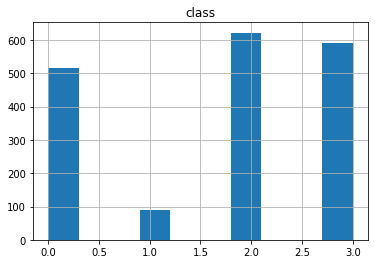

In [8]:
train_df.hist() # we have imbalanced data!

In [13]:
train_df['class'].value_counts(sort=False)

0    516
1     91
2    622
3    592
Name: class, dtype: int64

# Create ImageList Object Using DataBlocks API

In [0]:
seed = np.random.seed(42)
src = (ImageList.from_df(train_df, root_dir, folder='images', suffix='.jpg')
       .split_by_rand_pct(seed=seed)
       .label_from_df()
       .add_test(test_data))

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.5, max_rotate=90.0)

data = (src.transform(tfms, size=224)
      .databunch(bs=64)
      .normalize(imagenet_stats))

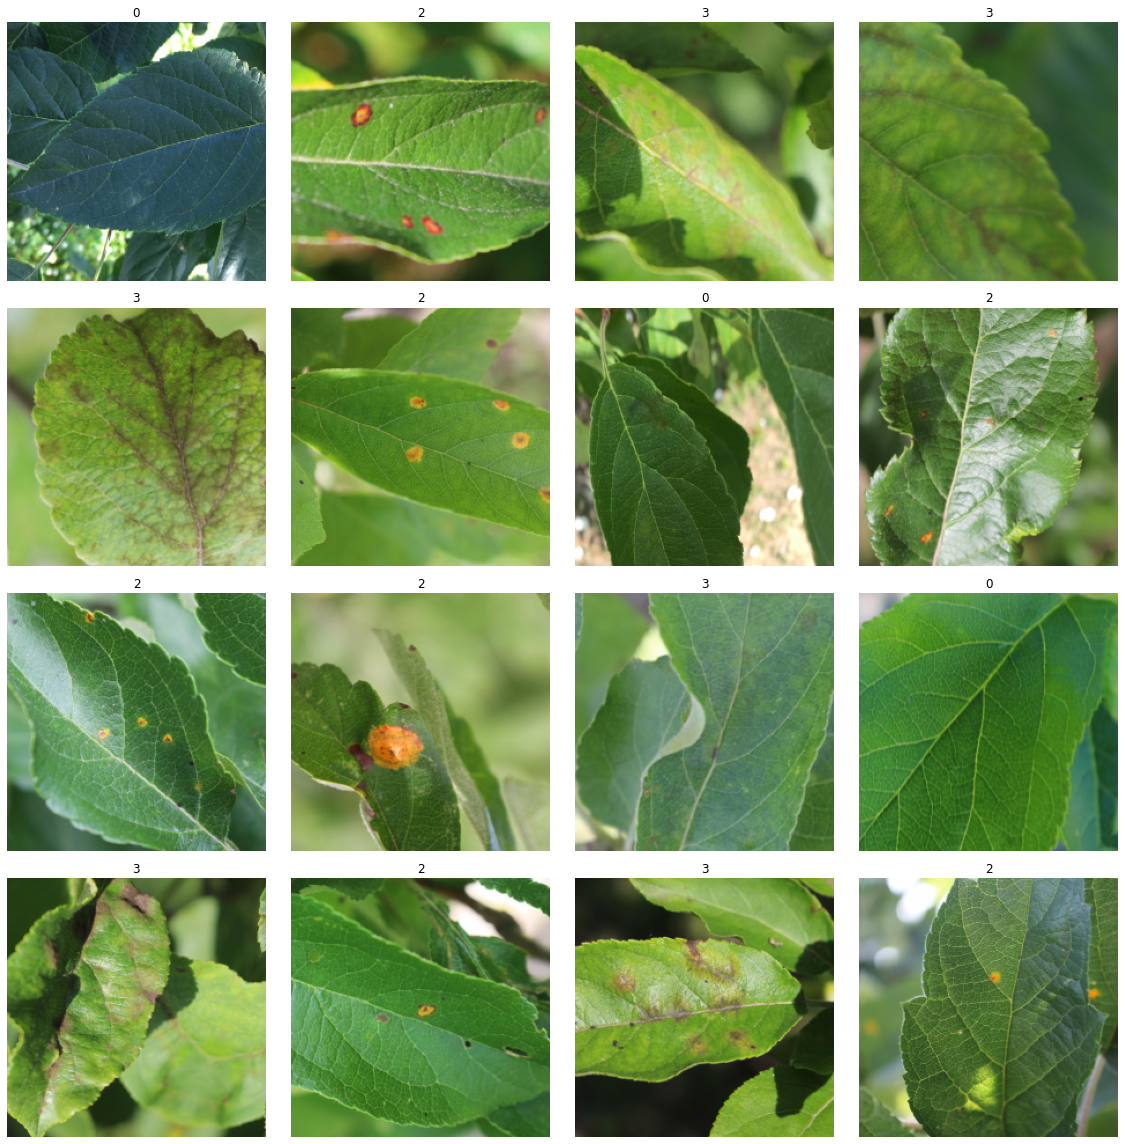

In [15]:
data.show_batch(rows=4)

# Training

In [0]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy(), target.cpu().numpy()
    return roc_auc_score(input, target)

@dataclass
class AUC(Callback):
    clas:int=1
    _order = -30
    
    def __init__(self, clas, **kwargs):
        super().__init__()
        self.clas = clas
        self.temp_list = ["healthy", "multiple_diseases", "rust", "scab"]
        self.name = "auc_" + str(self.temp_list[self.clas])
        self.roc = 0
    
    def on_epoch_begin(self, **kwargs):
        self.output, self.target = [], []
    
    def on_batch_end(self, last_output, last_target, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            considered_clas = self.clas
            indexes = (target == considered_clas)
            target_for_roc = torch.zeros(target.size())
            target_for_roc[indexes] = 1
            probs = F.softmax(output, dim = 1)
            pfinal = probs[:, considered_clas]
            self.metric = auroc_score(target_for_roc, pfinal)
            self.roc = self.metric
        return add_metrics(last_metrics, self.metric)

In [0]:
class MeanAUC(Callback):
    _order = -20
    
    def __init__(self, auc0, auc1, auc2, auc3):
        super().__init__()
        self.name = "Mean AUC"
        self.auc0 = auc0
        self.auc1 = auc1
        self.auc2 = auc2
        self.auc3 = auc3
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, (self.auc0.roc + self.auc1.roc + self.auc2.roc + self.auc3.roc) / 4)

The following cell integrates the Neptune API with the Fastai framework. Neptune is an experiment management tool that is helpful for keeping track of experiments and logging metrics.

In [36]:
from fastai.callbacks import *
from neptunecontrib.monitoring.fastai import NeptuneMonitor

auc0 = AUC(clas=0)
auc1 = AUC(clas=1)
auc2 = AUC(clas=2)
auc3 = AUC(clas=3)
meanauc = MeanAUC(auc0, auc1, auc2, auc3)

arch = models.resnet50 # define model

with neptune.create_experiment(params={'lr':1e-3}):
  learn = cnn_learner(data, arch, metrics=[accuracy , error_rate, auc0, auc1, auc2, auc3, meanauc],
                        callback_fns=[NeptuneMonitor], wd=1e-3).to_fp32()
  learn.fit_one_cycle(5, 1e-3) # fit to our data

https://ui.neptune.ai/spregler/fastai/e/FAS-58


epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,1.421298,0.486682,0.843407,0.156593,0.966856,0.803147,0.973292,0.967220,0.927629,02:07
1,0.930770,0.499250,0.879121,0.120879,0.977008,0.874920,0.989754,0.969321,0.952751,02:06
2,0.714314,0.447806,0.887363,0.112637,0.977292,0.845697,0.991906,0.971922,0.946704,02:06
3,0.584681,0.402130,0.898352,0.101648,0.985795,0.882306,0.993887,0.977491,0.959870,02:07
4,0.487004,0.393360,0.890110,0.109890,0.986591,0.886641,0.994501,0.978691,0.961606,02:06


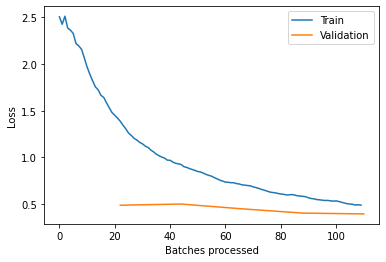

In [37]:
learn.recorder.plot_losses()

https://ui.neptune.ai/spregler/fastai/e/FAS-59


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 6.31E-06


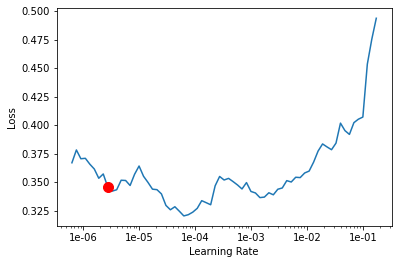

In [38]:
with neptune.create_experiment():
  learn.lr_find() # find optimal lr
  learn.recorder.plot(suggestion=True)

In [39]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [0]:
learn.save('resnet50-stage0')
learn.load('resnet50-stage0')
learn.unfreeze()

In [42]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
___________________________________________________

In [43]:
with neptune.create_experiment():
  learn.fit_one_cycle(5, slice(2.75e-06,6.35e-06))

https://ui.neptune.ai/spregler/fastai/e/FAS-60


epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,0.337366,0.396710,0.887363,0.112637,0.986288,0.890495,0.994604,0.978191,0.962394,02:15
1,0.308807,0.367549,0.903846,0.096154,0.987083,0.897078,0.995150,0.980559,0.964968,02:12
2,0.306176,0.345288,0.909341,0.090659,0.987348,0.899807,0.995253,0.982093,0.966125,02:10
3,0.295353,0.360175,0.901099,0.098901,0.986780,0.893224,0.995321,0.982026,0.964338,02:07
4,0.299390,0.352506,0.909341,0.090659,0.986780,0.897720,0.995560,0.981993,0.965513,02:08


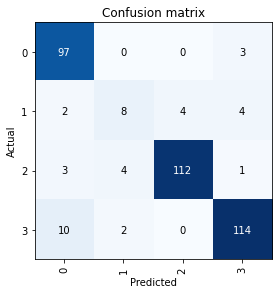

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

https://ui.neptune.ai/spregler/fastai/e/FAS-61


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.92E-05


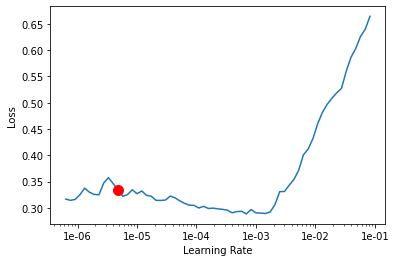

In [46]:
with neptune.create_experiment():
  learn.lr_find() # find optimal lr
  learn.recorder.plot(suggestion=True)

In [47]:
with neptune.create_experiment():
  learn.fit_one_cycle(6, slice(4.79e-05,1e-04))

https://ui.neptune.ai/spregler/fastai/e/FAS-62


epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,0.321098,0.338195,0.909341,0.090659,0.987235,0.915864,0.996892,0.982860,0.970713,02:08
1,0.291011,0.289525,0.923077,0.076923,0.990758,0.956326,0.996858,0.983327,0.981817,02:08
2,0.276580,0.255097,0.931319,0.068681,0.990758,0.961143,0.996824,0.990163,0.984722,02:07
3,0.256396,0.215437,0.936813,0.063187,0.991061,0.979608,0.997951,0.991430,0.990012,02:07
4,0.225302,0.211315,0.934066,0.065934,0.991402,0.974952,0.997643,0.992597,0.989148,02:06
5,0.217083,0.203427,0.936813,0.063187,0.991856,0.974952,0.997575,0.992997,0.989345,02:08


In [0]:
learn.save('resnet50-stage1')
learn.load('resnet50-stage1')
learn.export()

In [68]:
learn.freeze()
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [69]:
with neptune.create_experiment():
  learn.fit_one_cycle(5, 1e-03)

https://ui.neptune.ai/spregler/fastai/e/FAS-64


epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,0.285400,0.296911,0.912088,0.087912,0.985568,0.947656,0.996038,0.989229,0.979623,02:05
1,0.273053,0.215777,0.923077,0.076923,0.993826,0.962909,0.996175,0.992464,0.986343,02:07
2,0.247520,0.185242,0.961538,0.038462,0.991742,0.958895,0.998019,0.994965,0.985905,02:07
3,0.210556,0.194870,0.953297,0.046703,0.992689,0.949422,0.998531,0.994231,0.983718,02:07
4,0.196620,0.195764,0.953297,0.046703,0.992045,0.950706,0.998770,0.993798,0.983830,02:07


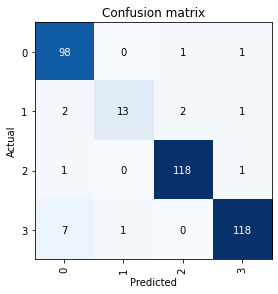

In [87]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [88]:
with neptune.create_experiment():
  learn.fit_one_cycle(5, 1e-03)

https://ui.neptune.ai/spregler/fastai/e/FAS-65


epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,0.153414,0.177785,0.958791,0.041209,0.991477,0.956166,0.999146,0.994698,0.985372,02:07
1,0.157642,0.203871,0.956044,0.043956,0.993409,0.954721,0.998019,0.995331,0.985370,02:06
2,0.156794,0.195300,0.947802,0.052198,0.991591,0.953276,0.999146,0.992830,0.984211,02:06
3,0.142458,0.160377,0.956044,0.043956,0.993447,0.967084,0.999112,0.994631,0.988569,02:07
4,0.141997,0.160298,0.961538,0.038462,0.993333,0.968369,0.999214,0.994765,0.988920,02:07


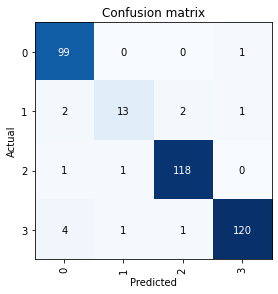

In [93]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn = load_learner(root_dir, test_data)

# Kaggle Submission


In [89]:
preds, y = learn.get_preds(DatasetType.Test)

In [0]:
preds_np = preds.numpy()
pred_df = pd.DataFrame(preds_np)

In [90]:
pred_df.head()

,0,1,2,3
0,2.043693e-06,5.551041e-05,9.999424e-01,1.430203e-08
1,8.230477e-08,1.344695e-04,9.998654e-01,5.109864e-08
2,5.452895e-05,5.971690e-04,2.425893e-09,9.993483e-01
3,9.999958e-01,1.607429e-07,3.401900e-06,6.221846e-07
4,7.379073e-09,4.644242e-06,9.999954e-01,1.487114e-09


In [0]:
sample_df = pd.read_csv(root_dir/'sample_submission.csv')
sample_df.iloc[:,1:] = preds.numpy()
sample_df.to_csv('submission.csv', index=False)

In [92]:
sample_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,5.189956e-07,1.250661e-04,9.998744e-01,1.392260e-09
1,Test_1,7.403260e-08,9.893463e-04,9.990106e-01,1.581045e-08
2,Test_2,8.431078e-06,3.328399e-05,2.328574e-09,9.999583e-01
3,Test_3,9.999884e-01,2.086691e-07,2.564696e-06,8.693208e-06
4,Test_4,9.440456e-08,4.671803e-04,9.995327e-01,3.736248e-09


# Conclusion:
The end model was able to acheive a score of .949 on the kaggle challenge learderboard: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/leaderboard

The origninal paper outlining this challenge can be found: https://arxiv.org/abs/2004.11958